In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold

In [2]:
# Day1はCategoryなどの分析を入れず、backersのような最初にないデータを使って解析しました。
# 今回はまず最初にないデータを取り外し、Day1のやり方で、比較用の結果を出します。

df_ks = pd.read_csv("ks-projects-201801.csv").drop(columns=["ID", "name", "goal", "pledged", "usd_pledged_real","backers"])
df_ks = df_ks.dropna()

# convert 'state' to int-like boolean
df_ks['state'] = (df_ks['state'] == 'successful').astype(int)

# calculate time limit column
df_ks['deadline'] = pd.to_datetime(df_ks['deadline'])
df_ks['launched'] = pd.to_datetime(df_ks['launched'])
df_ks['time_limit'] = (df_ks['deadline'] - df_ks['launched']).dt.total_seconds()
df_ks.drop(columns=['launched', 'deadline'], inplace=True)

display(df_ks.head())
print(df_ks.shape)

,category,main_category,currency,state,country,usd pledged,usd_goal_real,time_limit
0,Poetry,Publishing,GBP,0,GB,0.0,1533.95,5053652.0
1,Narrative Film,Film & Video,USD,0,US,100.0,30000.00,5166963.0
2,Narrative Film,Film & Video,USD,0,US,220.0,45000.00,3886750.0
3,Music,Music,USD,0,US,1.0,5000.00,2579749.0
4,Film & Video,Film & Video,USD,0,US,1283.0,19500.00,4807497.0


(374864, 8)


In [3]:
# string列を[get_dummies]で数値化, 数が少ない分類をdrop
def get_dm(df, column, th=200):
    dm = pd.get_dummies(df[column])
    dm.loc[-1] = dm.sum(axis=0)
    for c in dm.columns:
        if dm.loc[-1][c] <= th:
            dm = dm.drop(columns=[c])
    return dm.drop(-1)

In [4]:
# string列のtag
dm_pool = ["category","main_category","currency","country"]

df_ks2 = df_ks

for i in dm_pool:
    df_ks2 = pd.concat([df_ks2, get_dm(df_ks2, i, 2000)], axis=1, sort=False)
    df_ks2 = df_ks2.drop(columns=[i])

display(df_ks2.head())
print(df_ks2.shape)

,state,usd pledged,usd_goal_real,time_limit,Accessories,Animation,Apparel,Apps,Art,Art Books,...,USD,AU,CA,DE,ES,FR,GB,IT,NL,US
0,0,0.0,1533.95,5053652.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,100.0,30000.00,5166963.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,220.0,45000.00,3886750.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,1.0,5000.00,2579749.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,1283.0,19500.00,4807497.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


(374864, 86)


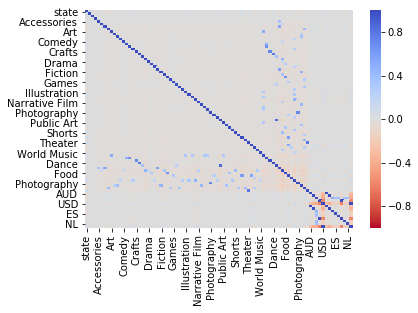

In [8]:
sns.heatmap(df_ks2.corr(),cmap="coolwarm_r",vmin=-1,vmax=1)

In [10]:
def linear_ev(regr, X, y):
    # 値を予測
    y_pred = regr.predict(X)

    # MSEを計算
    mse = mean_squared_error(y, y_pred) 
    print("MSE = %s"%round(mse,3) )  

    # MAEを計算
    mae = mean_absolute_error(y, y_pred) 
    print("MAE = %s"%round(mae,3) )

    # RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )

In [23]:
# target: state
y = df_ks2['state'].values
X = df_ks2.drop(columns=['state']).values

In [24]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X, y)
# clf = SGDClassifier(loss='log', penalty='none',tol = 'none', max_iter=10000, fit_intercept=True, random_state=1234)


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -3.045
正答率 = 91.184%


In [26]:
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=[' 予測= successful', '予測 = failed'], 
                        columns=['正解 = successful', '正解 = failed'])
conf_mat

,正解 = successful,正解 = failed
予測= successful,225726,15287
予測 = failed,17760,116091


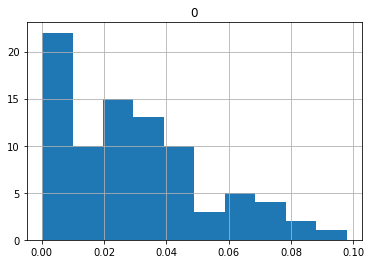

In [40]:
# 各Xとｙの相関度をみる
coefs = np.abs([np.corrcoef(df_ks2["state"], df_ks2[[c]].T)[0,1] for c in df_ks2.drop(columns=['state']).columns])
coefs_h = pd.DataFrame(coefs)
coefs_h.hist()
plt.show()

In [41]:
# 解析時間の考慮で、相関度の高い列を一部dropし、残るのを白色化
drop_c_index = [i for i in range(len(coefs)) if coefs[i] > 0.05]
drop_c = df_ks2.drop(columns=['state']).columns[drop_c_index]
print(drop_c)
df_ks_d = df_ks2.drop(columns=drop_c)

display(df_ks_d.head())
print(df_ks_d.shape)

Index(['usd pledged', 'Apps', 'Country & Folk', 'Dance', 'Indie Rock',
       'Shorts', 'Tabletop Games', 'Theater', 'Video Games', 'Web', 'Dance',
       'Theater', 'EUR', 'USD', 'US'],
      dtype='object')


,state,usd_goal_real,time_limit,Accessories,Animation,Apparel,Art,Art Books,Children's Books,Classical Music,...,CAD,GBP,AU,CA,DE,ES,FR,GB,IT,NL
0,0,1533.95,5053652.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,30000.00,5166963.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,45000.00,3886750.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,5000.00,2579749.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,19500.00,4807497.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(374864, 71)


In [42]:
#  無相関化を行うための一連の処理
cov = np.cov(df_ks_d['state'], df_ks_d.drop(columns=['state']), rowvar=0) # 分散・共分散を求める
_, S = np.linalg.eig(cov)           # 分散共分散行列の固有ベクトルを用いて
ks_d_decorr = np.dot(S.T, df_ks_d.T).T #データを無相関化

In [43]:
#  白色化を行うための一連の処理
stdsc = StandardScaler()
stdsc.fit(ks_d_decorr)
ks_d_wht = stdsc.transform(ks_d_decorr) # 無相関化したデータに対して、さらに標準化
df_ks_d_wht = pd.DataFrame(ks_d_wht, columns=df_ks_d.columns)
print (df_ks_d_wht.shape)

(374864, 71)


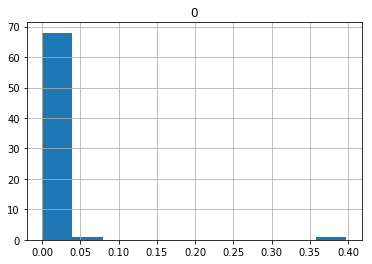

In [44]:
# 各Xとｙの相関度をみる
coefs = np.abs([np.corrcoef(df_ks_d_wht["state"], df_ks_d_wht[[c]].T)[0,1] for c in df_ks_d_wht.drop(columns=['state']).columns])
coefs_h = pd.DataFrame(coefs)
coefs_h.hist()
plt.show()

In [10]:
# 白色化でstateが整数でなくなるため、Xだけを標準化する
coefs = np.abs([np.corrcoef(df_ks2["state"], df_ks2[[c]].T)[0,1] for c in df_ks2.drop(columns=['state']).columns])
coefs_h = pd.DataFrame(coefs)

# 相関度の高い列を捨てる
drop_c_index = [i for i in range(len(coefs)) if coefs[i] > 0.04]
drop_c = df_ks2.drop(columns=['state']).columns[drop_c_index]
print(drop_c)
df_ks_d = df_ks2.drop(columns=drop_c)

display(df_ks_d.head())
print(df_ks_d.shape)

Index(['usd pledged', 'Apparel', 'Apps', 'Classical Music', 'Comic Books',
       'Country & Folk', 'Dance', 'Hip-Hop', 'Indie Rock', 'Music', 'Rock',
       'Shorts', 'Software', 'Tabletop Games', 'Technology', 'Theater',
       'Video Games', 'Web', 'Dance', 'Music', 'Technology', 'Theater', 'EUR',
       'USD', 'US'],
      dtype='object')


,state,usd_goal_real,time_limit,Accessories,Animation,Art,Art Books,Children's Books,Comedy,Comics,...,CAD,GBP,AU,CA,DE,ES,FR,GB,IT,NL
0,0,1533.95,5053652.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0,30000.00,5166963.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,45000.00,3886750.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,5000.00,2579749.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,19500.00,4807497.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(374864, 61)


In [12]:
mms = MinMaxScaler()
df_ks_d_n = mms.fit_transform(df_ks_d.values)

df_ks_d_n = pd.DataFrame(df_ks_d_n, columns=df_ks_d.columns)
display(df_ks_d_n.head())
print(df_ks_d_n.shape)

,state,usd_goal_real,time_limit,Accessories,Animation,Art,Art Books,Children's Books,Comedy,Comics,...,CAD,GBP,AU,CA,DE,ES,FR,GB,IT,NL
0,0.0,0.000009,0.003494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.000180,0.003572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000270,0.002687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000030,0.001783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000117,0.003324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(374864, 61)


In [13]:
# target: state
y2 = df_ks_d_n['state'].values
X2 = df_ks_d_n.drop(columns=['state']).values

In [14]:
# ホールドアウト + 交差検証
X_rs = X2.reshape(-1,1) # scikit-learnに入力するために整形
test_size = 0.4        
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

n_split = 3

cross_valid_ac = 0
split_num = 1

In [15]:
# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X_train, y_train):
    X_tr, y_tr = X_train[train_idx], y_train[train_idx] #学習用データ
    X_te, y_te = X_train[test_idx], y_train[test_idx]     #テスト用データ
    
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
    clf.fit(X_tr, y_tr)
    
    y_est = clf.predict(X_te)
    
    # 正答率を表示
    print("Fold %s"%split_num)
    print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_te, y_est)))
    
    cross_valid_ac += 100 * accuracy_score(y_te, y_est)
    split_num += 1
    
final_ac = cross_valid_ac / n_split
print("Cross Validation AC = %s"%round(final_ac, 3))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Fold 1
正答率 = 64.409%


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Fold 2
正答率 = 64.697%


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Fold 3
正答率 = 64.988%


NameError: name 'final_ac' is not defined

In [16]:
final_ac = cross_valid_ac / n_split
print("Cross Validation AC = %s"%round(final_ac, 3))

Cross Validation MAE = 64.698


In [17]:
y_est = clf.predict(X_test)
print("Fold %s"%split_num)
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_est)))

Fold 4
正答率 = 64.609%
